## **EXP6 Predicting Real Missing Cell-Types from Bulks using Non-Negative Least Squares Regression Residual**

*This file includes EXP3 analysis. Files used as references (sc and sn RNA-seq) were created in preprocessing/EXP3_pseudos notebook.*

**Summary:**
Using single nucleus and single cell RNA-seq datasets to deconvolve real bulks of adipose tissue. We then calculate the residuals of both proportions and perform NMF. Gene ontology analysis is then done on the genes contributing to each component. Bulk RNA-seq files originate from https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE174475. Please download before running this notebook. 

**Hypothesis:**
Deconvolving bulks with references missing cell types will give a residual from which we can extract missing cell type information. 

**Deconv. Method:**
NNLS

**Factorization Methods:**
NMF

In [99]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
from numpy.linalg import norm
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import sklearn as sk
from sklearn.preprocessing import FunctionTransformer
import matplotlib.colors as mcolors
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.stats import wilcoxon

from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
from scipy.stats import kruskal
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns
from openTSNE import TSNE
from openTSNE import TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.utils import resample
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# programming stuff
import time
import os, sys, glob
import pickle
from pathlib import Path

These parameters are set in EXP3.py file and can be run through paperpill using run_EXP3.sh file.

In [100]:
#####################
### set the study ###
#####################
#paths:
res_name = f"MCT_adp_EXP3"
pseudo_name = "MCT_adp_EXP3"
files_path = "/../data/EXP3/"
path_results = "/../results/EXP3/"
data_path = "/../data/EXP3/cibersort/"
cibersort_files = "/../data/EXP3/cibersort_results/realisticprop_nonoise_0missing/\
CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_phenoclasses.CIBERSORTx_\
MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_refsample.bm.K999.txt"
bulks_path = "/../data/EXP6/GSE174475_RAW/"
###### set your random seed, num missing cells, and num_samples for reference for reproducibility
random_seed = 88
bulkprop_type = "realistic"
noise_type = "nonoise"
bulk_type = f"{bulkprop_type}prop_{noise_type}"
num_samples = 10000
#how to handle negative residual distribution for NMF
nmf_cut = "minimum_value"
#and kernel environment
kernel_name = "env_ml"

In [101]:
#font for plots
font = {'fontname':'Arial'}

#parameters into paths
actual_path = os.getcwd()
path = f"{actual_path}{files_path}"
aug_data_path = f"{actual_path}{files_path}"
cibersort_path = f"{actual_path}{cibersort_files}"
path_results = f"{actual_path}{path_results}"
data_path = f"{actual_path}{data_path}"
bulks_path = f"{actual_path}{bulks_path}"

Import the previously processed datasets. 

*See preprocessing/EXP3_pseudos.ipynb notebook for details.*

In [102]:
#and as anndata object single nucleus 
adata_path = os.path.join(path, f"{res_name}_snadata_notlog.h5ad")
adata_path = Path(adata_path)
sn_adata = sc.read_h5ad(adata_path)
sn_adata

AnnData object with n_obs × n_vars = 113017 × 28242
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [103]:
#and single cell
adata_path = os.path.join(path, f"{res_name}_scadata_notlog.h5ad")
adata_path = Path(adata_path)
sc_adata = sc.read_h5ad(adata_path)
sc_adata

AnnData object with n_obs × n_vars = 18490 × 26672
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'cell_types'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_var_genes'

In [104]:
#making sure cell types are capitalized:
sn_adata.obs["cell_types"] = vp.capitalize_first_letters(sn_adata.obs["cell_types"])
sc_adata.obs["cell_types"] = vp.capitalize_first_letters(sc_adata.obs["cell_types"])

In [105]:
sc_prop = vp.make_prop_table(sc_adata, "cell_types")
sc_prop = sc_prop[:-1]
sc_prop.sort_values("Cell_Types")
sc_prop.reindex()
sn_prop = vp.make_prop_table(sn_adata, "cell_types")
sn_prop = sn_prop[:-1]
sn_prop.sort_values("Cell_Types")
sn_prop.reindex()
sn_prop

,Cell_Types,Num_Cells,Prop_Cells
0,Mesothelial cell,26276,0.232496
1,Fat cell,24825,0.219657
2,Macrophage,13625,0.120557
3,Preadipocyte,26941,0.238380
4,Endothelial cell,11480,0.101578
5,Endothelial cell of lymphatic vessel,2339,0.020696
6,Pericyte cell,1165,0.010308
7,T cell,3022,0.026739
8,Dendritic cell,679,0.006008
9,Mast cell,883,0.007813


Cells Missing from Real Proportions (SN vs. SC):

In [106]:
cells_names = np.setdiff1d(sn_prop["Cell_Types"].values, sc_prop["Cell_Types"].values)
cells_to_miss_idx = list()
for cell in cells_names:
    cells_to_miss_idx.append(sn_prop.loc[sn_prop['Cell_Types'] == cell].index[0])
cells_to_miss_idx
num_missing_cells = [0, len(cells_to_miss_idx)]
num_missing_cells

[0, 2]

Importing CIBERSORTx results for genes:

In [107]:
cibersort_df = pd.read_csv(cibersort_path, sep="\t")
cibersort_genes = cibersort_df["NAME"].values.tolist()

And getting cell markers. See https://academic.oup.com/nar/article/51/D1/D870/6775381 for details.

In [108]:
#mesothelial markers from https://academic.oup.com/nar/article/51/D1/D870/6775381
markers_path = os.path.join(f"{bulks_path}../", f"CellMarkerMesothelial.csv")
markers_path = Path(markers_path)
markers_meso = pd.read_csv(markers_path)
markers_meso = markers_meso[markers_meso["Cancer"] == "Normal cell"]
markers_meso = markers_meso[markers_meso["Species"] == "Human"]
markers_meso = markers_meso["Cell marker"].values.tolist()
#deleting genes that are also highly expressed in others, verified by Human Protein Atlas: 
# https://www.proteinatlas.org/ 
markers_meso = np.array(markers_meso)
markers_meso = [
 'MSLN',
 'UPK3B',
 'IL18',
 'SOX6',
 'WNT10A',
 'UPK3B',
 'WT1',
 'UPK3B',
 'MSLN',
 'PRG4',
 'UPK3B',
 'LRRN4',
 'UPK3B']

In [109]:
#From original data's deconv paper: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03077-7
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]
#adipocyte markers from CellMarker: https://academic.oup.com/nar/article/51/D1/D870/6775381
markers_path = os.path.join(f"{bulks_path}../", f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']
# Convert the lists to pandas Series if they are not already
cibersort_genes = pd.Series(cibersort_genes)
adip_markers = pd.Series(adip_markers)
eryth_markers = pd.Series(eryth_markers)
diss_response = pd.Series(diss_response)
markers_meso = pd.Series(markers_meso)
# Merge all gene sets into the existing gene_ids Series
gene_ids = pd.concat([cibersort_genes, adip_markers, eryth_markers, diss_response, markers_meso], ignore_index=True).unique()
# Display the updated gene_ids
gene_ids.shape

/var/folders/d3/x10lxf7x1n37__s3n36qxmlw0000gp/T/ipykernel_43838/759652558.py:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  adip_markers = np.array(adip_markers)


(2938,)

In [110]:
gene_ids = np.intersect1d(gene_ids, sn_adata.var_names)
gene_ids = np.intersect1d(gene_ids, sc_adata.var_names)
print("Now we have these genes in common with anndatas: ", gene_ids.shape)
sn_adata = sn_adata[:, gene_ids]
sc_adata = sc_adata[:, gene_ids]
gene_ids.shape

Now we have these genes in common with anndatas:  (2782,)


(2782,)

## Import bulks: 

The original counts DataFrame (counts_df) contains RNA-seq read counts at the transcript level. However, you want the counts at the gene level. This requires aggregating the counts of transcripts that belong to the same gene.

To do this, we use a mapping file (mapping_df) that links transcripts (e.g., ENST00000561901.1) to their corresponding genes (e.g., ZNF707).

In [111]:
#In Gencode there's transcript-to-gene mappings under "Metadata files" (for HGNC gene symbols):
mapping_df = pd.read_csv(f"{bulks_path}/../gencode.v19.metadata.HGNC.gz", sep='\t', compression='gzip', header=None)
mapping_df

,0,1
0,ENST00000561901.1,ZNF707
1,ENST00000563401.1,ZNF707
2,ENST00000564532.1,ZNF707
3,ENST00000568639.1,ZNF707
4,ENST00000567611.1,ZNF707
...,...,...
178976,ENST00000601327.1,TMLHE
178977,ENST00000596345.1,TMLHE
178978,ENST00000595698.1,TMLHE
178979,ENST00000593585.1,TMLHE


In [112]:
# Create an empty dictionary to store the `NumReads` data
count_data = {}

# Get a list of all `.tsv.gz` files in the directory
file_list = glob.glob(os.path.join(bulks_path, "*.quants.tsv.gz"))

# Loop through each file
for file in file_list:
    # Extract the GSM identifier from the filename
    gsm_id = os.path.basename(file).split('_')[0]
    # Read the file into a DataFrame
    df = pd.read_csv(file, sep='\t', compression='gzip', index_col=0)
    # Extract the `NumReads` column and store it in the dictionary
    count_data[gsm_id] = df['NumReads']

# Combine all `NumReads` columns into a single DataFrame
counts_df = pd.DataFrame(count_data)
counts_df

,GSM5315252,GSM5315242,GSM5315263,GSM5315270,GSM5315255,GSM5315265,GSM5315259,GSM5315253,GSM5315238,GSM5315257,...,GSM5315272,GSM5315245,GSM5315268,GSM5315258,GSM5315273,GSM5315244,GSM5315256,GSM5315237,GSM5315260,GSM5315232
Name,,,,,,,,,,,,,,,,,,,,,
ENST00000473358.1,0.0,0.000,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.000,...,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.000,0.0,0.0
ENST00000469289.1,0.0,1.174,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.000,0.0,0.0
ENST00000607096.1,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333,0.0,0.0
ENST00000417324.1,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
ENST00000461467.1,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSTR0000424344.3,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
ENSTR0000369423.2,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0
ENSTR0000540897.1,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0


In [113]:
# Ensure consistent column names for clarity
mapping_df.columns = ["Transcript", "Gene"]

# Remove the transcript version suffix (e.g., `.1`) for consistency, if needed
mapping_df['Transcript'] = mapping_df['Transcript'].str.split('.').str[0]
counts_df.index = counts_df.index.str.split('.').str[0]

# Merge the counts with the mapping on the transcript ID
merged_df = counts_df.merge(mapping_df, left_index=True, right_on="Transcript")

# Group by the gene name and sum the counts
bulks= merged_df.groupby("Gene").sum().T

# Display the resulting gene-level counts DataFrame
bulks

Gene,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
GSM5315252,13.782,11.115,16853.239,4.018,1.0,431.000,27.000,515.001,1003.598,102.000,...,142.245,31.000,208.122,384.377,735.000,1.006,2736.117,3129.898,3471.895,740.037
GSM5315242,38.024,0.000,29161.380,12.310,1.0,554.000,9.000,651.000,1013.060,369.994,...,176.811,51.000,347.051,561.949,994.000,3.041,5080.250,2687.953,3976.398,1562.944
GSM5315263,26.933,5.012,39481.920,7.121,8.0,499.999,0.000,433.000,2642.521,1111.914,...,296.416,50.000,435.925,886.075,1028.000,2.055,4515.947,2134.650,3281.756,1567.420
GSM5315270,26.939,5.000,36869.697,30.848,0.0,478.000,2.000,528.000,804.583,1092.000,...,216.638,24.000,376.793,635.806,855.999,6.358,3210.836,2020.492,3204.413,1291.831
GSM5315255,23.746,8.061,11394.652,7.314,0.0,533.999,10.000,731.999,1895.920,122.000,...,98.741,37.000,289.821,501.179,1380.000,9.039,3862.410,2020.764,4470.615,856.120
GSM5315265,29.341,1.000,20675.531,7.117,3.0,622.001,8.000,524.999,1333.976,1221.918,...,273.117,34.000,407.307,745.697,1063.000,4.032,4258.082,3238.985,3478.191,1961.061
GSM5315259,8.398,7.054,25949.399,10.060,1.0,299.999,2.025,337.999,909.518,258.000,...,164.611,20.000,380.181,454.387,565.000,6.054,2820.979,783.724,1584.007,1200.052
GSM5315253,24.523,6.000,9194.111,15.136,2.0,213.000,5.000,566.001,1954.946,60.832,...,101.752,42.000,158.455,489.545,930.001,4.108,3029.165,2655.731,3526.415,735.011
GSM5315238,47.457,2.005,33377.863,4.057,4.0,631.001,1.000,404.999,972.859,1023.000,...,316.373,47.000,313.535,539.468,1058.000,18.388,2953.012,3990.393,3889.255,1601.238
GSM5315257,12.713,1.000,14183.961,10.043,1.0,319.000,10.000,1065.000,3805.935,292.000,...,132.901,74.999,380.853,712.147,1479.000,1.017,4091.350,2753.112,5870.470,1247.461


In [114]:
#extracting gene_ids and setting as columns
gene_ids = pd.Series(gene_ids)
gene_ids = np.intersect1d(bulks.columns, gene_ids)
bulks = bulks[gene_ids]
print("Now we have these genes in common with anndatas: ", gene_ids.shape)
sn_adata = sn_adata[:, gene_ids]
sc_adata = sc_adata[:, gene_ids]
bulks

Now we have these genes in common with anndatas:  (2416,)


Gene,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
GSM5315252,332.000,134.006,388.381,1880.876,1331.671,49.136,463.000,1553.686,112.043,272.016,...,18.0,474.097,650.000,30.000,105.029,362.000,741.440,103.000,56.0,1335.464
GSM5315242,591.000,151.960,697.268,7757.170,2175.192,45.056,838.000,1087.968,182.069,821.008,...,13.0,1132.401,1060.320,39.000,246.001,472.970,1283.646,332.000,73.0,1809.413
GSM5315263,604.999,248.630,2145.631,8292.218,6444.051,48.505,889.000,91.000,183.000,424.024,...,0.0,1143.389,558.001,48.000,325.022,362.966,745.310,149.204,79.0,1595.908
GSM5315270,470.000,196.532,1747.594,4812.391,2835.879,66.001,512.000,325.131,136.032,486.999,...,8.0,899.929,666.001,24.000,276.751,492.741,797.010,212.152,126.0,1365.292
GSM5315255,550.000,184.654,560.328,2396.148,1027.386,96.069,695.000,332.591,36.856,287.000,...,6.0,720.797,994.000,8.000,145.008,493.001,1041.884,162.097,87.0,2212.750
GSM5315265,748.000,256.883,2592.832,9944.016,5596.621,37.806,625.000,157.427,254.000,796.000,...,6.0,1018.558,749.999,56.000,364.072,428.000,675.842,169.001,200.0,1501.257
GSM5315259,313.001,155.144,946.124,3544.132,2140.396,24.000,434.000,25.002,101.000,238.001,...,0.0,789.608,563.000,12.000,211.223,241.999,329.544,195.000,69.0,873.681
GSM5315253,390.999,236.864,465.115,2984.087,1371.131,11.999,557.000,1421.367,54.956,307.000,...,3.0,447.184,586.999,15.000,154.003,423.936,816.269,96.001,33.0,1899.217
GSM5315238,670.000,232.460,759.293,5109.505,3653.562,28.001,721.000,698.018,387.119,719.045,...,75.0,885.257,333.797,153.000,242.093,335.961,544.910,97.001,58.0,1429.607
GSM5315257,599.000,345.577,494.785,4881.201,1291.379,13.000,773.000,928.646,71.089,530.999,...,17.0,833.420,915.001,8.000,204.113,457.000,1006.410,182.307,29.0,2753.008


## Creating reference profiles from single cell and single nucleus:


1. ref_raw is the sum of each gene expression per num_samples of each cell type. This is not scaled (raw). Once it is clipped and scaled with MinMax(), it becomes:
2. ref_df, which is used in NNLS. 

In [115]:
# Making cell type reference without scaling
cell_types_sc = sc_adata.obs["cell_types"].unique()
ref_raw_sc = pd.DataFrame(index = gene_ids, columns = cell_types_sc)
for cell_type in cell_types_sc:
    cell_df = sc_adata[sc_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw_sc[cell_type] = sum_over_genes.values
ref_raw_sc = ref_raw_sc.reindex(sorted(ref_raw_sc.columns), axis=1)
ref_raw_sc

,Dendritic cell,Endothelial cell,Endothelial cell of lymphatic vessel,Immature nk t cell,Macrophage,Mast cell,Monocyte,Pericyte cell,Preadipocyte,T cell
AATF,1514.0,1691.0,2089.0,1960.0,2058.0,2376.0,1896.0,1658.0,1262.0,1236.0
ABAT,606.0,239.0,315.0,364.0,577.0,390.0,600.0,394.0,372.0,559.0
ABCA10,706.0,958.0,608.0,1004.0,560.0,543.0,633.0,1155.0,10661.0,734.0
ABCA8,793.0,611.0,1884.0,808.0,792.0,733.0,794.0,2318.0,9979.0,771.0
ABCA9,1546.0,1347.0,957.0,1355.0,900.0,358.0,1154.0,3694.0,22023.0,1433.0
...,...,...,...,...,...,...,...,...,...,...
ZNRF1,751.0,2371.0,1451.0,196.0,633.0,1799.0,537.0,948.0,672.0,315.0
ZNRF3,296.0,979.0,190.0,285.0,301.0,0.0,273.0,1669.0,600.0,96.0
ZSCAN31,35.0,120.0,0.0,43.0,107.0,0.0,29.0,399.0,61.0,0.0
ZSWIM5,837.0,992.0,1152.0,426.0,594.0,565.0,557.0,1092.0,727.0,581.0


In [116]:
# Making cell type reference without snaling
cell_types_sn = sn_adata.obs["cell_types"].unique()
ref_raw_sn = pd.DataFrame(index = gene_ids, columns = cell_types_sn)
for cell_type in cell_types_sn:
    cell_df = sn_adata[sn_adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw_sn[cell_type] = sum_over_genes.values
ref_raw_sn = ref_raw_sn.reindex(sorted(ref_raw_sn.columns), axis=1)
ref_raw_sn

,Dendritic cell,Endothelial cell,Endothelial cell of lymphatic vessel,Fat cell,Immature nk t cell,Macrophage,Mast cell,Mesothelial cell,Monocyte,Pericyte cell,Preadipocyte,T cell
AATF,2807.0,1883.0,1649.0,3021.0,2531.0,2756.0,1399.0,1843.0,3559.0,935.0,1732.0,2273.0
ABAT,1813.0,452.0,443.0,1556.0,962.0,2606.0,738.0,816.0,2494.0,490.0,801.0,927.0
ABCA10,1722.0,1453.0,1948.0,15261.0,1745.0,1088.0,1521.0,2174.0,1550.0,2477.0,56788.0,1409.0
ABCA8,1688.0,840.0,1186.0,16703.0,764.0,2392.0,840.0,9816.0,1130.0,8438.0,30404.0,1175.0
ABCA9,4713.0,876.0,1098.0,8582.0,1309.0,15688.0,1370.0,1026.0,2005.0,3757.0,46032.0,1293.0
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF1,1356.0,3674.0,2335.0,3194.0,328.0,1534.0,5375.0,1443.0,1181.0,1578.0,1660.0,756.0
ZNRF3,905.0,1375.0,958.0,6130.0,248.0,847.0,346.0,5792.0,345.0,890.0,2087.0,467.0
ZSCAN31,208.0,1214.0,435.0,847.0,234.0,267.0,260.0,2987.0,147.0,398.0,906.0,144.0
ZSWIM5,599.0,1782.0,4522.0,2165.0,1453.0,419.0,596.0,2735.0,416.0,1244.0,1736.0,2222.0


In [117]:
ref_df_raw = {}
ref_df_raw[0] = ref_raw_sn.copy()
ref_df_raw[2] = ref_raw_sc.copy()
cell_types={}
cell_types[0] = cell_types_sn
cell_types[2] = cell_types_sc

In [118]:
ref_df ={}
for type in ref_df_raw.keys():
    #clipping before scaling to 95th pecentile
    ref_raw_val = ref_df_raw[type].values
    clip_upper = np.quantile(ref_raw_val, 0.95)
    ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
    #and scaling to be between values 0 and 1 to use for NNLS
    scaler = MinMaxScaler()
    scaler.fit(ref_raw_val)
    ref_df_val = scaler.transform(ref_raw_val)
    ref_df_val = pd.DataFrame(ref_df_val, index = gene_ids, columns = cell_types[type])
    ref_df[type] = pd.DataFrame(ref_df_val, index = gene_ids, columns = cell_types[type]).sort_index(axis=1)
ref_df[0]

,Dendritic cell,Endothelial cell,Endothelial cell of lymphatic vessel,Fat cell,Immature nk t cell,Macrophage,Mast cell,Mesothelial cell,Monocyte,Pericyte cell,Preadipocyte,T cell
AATF,0.550754,0.391671,0.426490,0.291394,0.351746,0.255182,0.144691,0.434382,0.268026,0.216495,0.467169,0.285204
ABAT,0.385946,0.148869,0.403278,0.069947,0.143453,0.068554,0.075827,0.280561,0.123954,0.114205,0.240320,0.126276
ABCA10,0.239862,0.270038,0.168368,0.224851,0.218042,0.301452,0.383315,0.266479,1.000000,0.235374,1.000000,0.336426
ABCA8,0.174867,0.118229,0.370161,0.129990,0.181831,0.183533,1.000000,0.261217,1.000000,0.129990,1.000000,1.000000
ABCA9,0.310273,0.202567,1.000000,0.135561,0.200091,0.169915,0.581394,0.729335,1.000000,0.212007,1.000000,0.158773
...,...,...,...,...,...,...,...,...,...,...,...,...
ZNRF1,0.182759,0.050758,0.237386,0.568550,0.116991,0.361340,0.244195,0.209841,0.256884,0.831779,0.493957,0.223304
ZNRF3,0.053389,0.038378,0.131073,0.212781,0.072268,0.148250,0.137727,0.140048,0.322963,0.053543,0.948584,0.896310
ZSCAN31,0.022748,0.036211,0.041318,0.187866,0.022284,0.067316,0.061590,0.032188,0.140203,0.040235,0.130535,0.462237
ZSWIM5,0.064376,0.224851,0.064840,0.275764,0.343854,0.699778,0.192509,0.092695,0.268645,0.092231,0.334621,0.423240


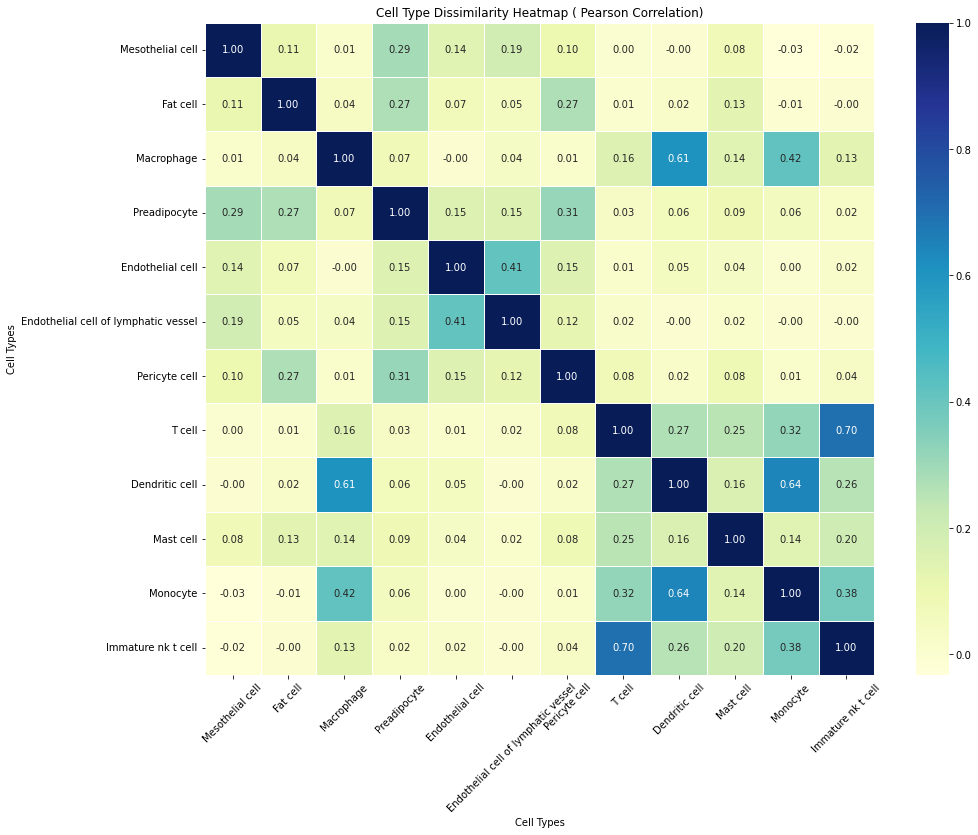

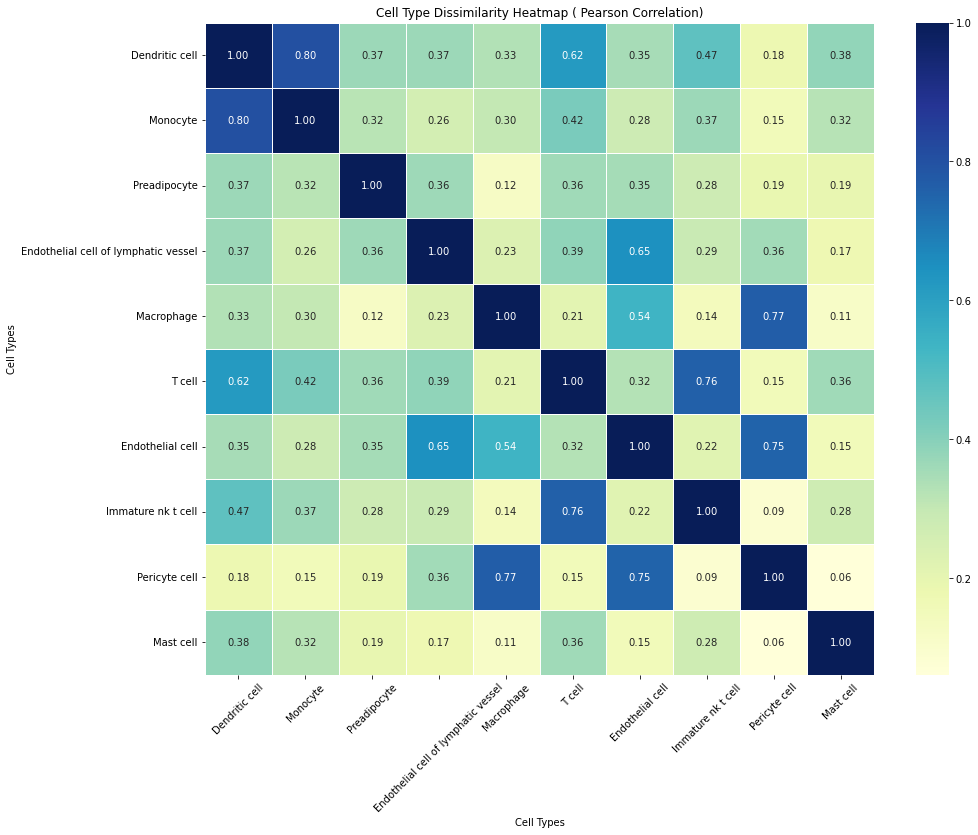

In [119]:
for type in ref_df.keys():
    # Define the number of samples for resampling
    num_samples = 10000

    # Making cell type reference without scaling
    if type ==0:
        adata = sn_adata
    elif type == 2:
        adata = sc_adata
    cell_types = adata.obs["cell_types"].unique()
    gene_ids = adata.var["gene_ids"]

    ref_raw = pd.DataFrame(index=gene_ids, columns=cell_types)

    for cell_type in cell_types:
        cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
        cell_sample = resample(cell_df, n_samples=num_samples, replace=True)
        x = cell_sample.X.sum(axis=0)
        sum_over_genes = pd.DataFrame(x).T
        ref_raw[cell_type] = sum_over_genes.values

    # Calculate Pearson correlations
    correlation_matrix = ref_raw.corr()

    # Create a DataFrame for the similarity matrix
    cell_types_similarity =correlation_matrix  # Convert correlations to dissimilarities
    similarity_df = pd.DataFrame(cell_types_similarity, columns=cell_types, index=cell_types)

    # Create a heatmap to visualize the similarities
    plt.figure(figsize=(15, 12))
    sns.heatmap(similarity_df, cmap="YlGnBu", annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Cell Type Dissimilarity Heatmap ( Pearson Correlation)")
    plt.xlabel("Cell Types")
    plt.ylabel("Cell Types")
    plt.xticks(rotation=45)
    plt.show()

Using the same bulk for all three deconv. methods:

In [120]:
#clippign before scaling to 95th pecentile
pseudo_copy = bulks.copy() #keeping genes
bulks = bulks.values #np array
clip_upper = np.quantile(bulks, 0.95)
bulks = np.clip(bulks, 0, clip_upper)
#and normalize to values between 0 and 1
scaler = MinMaxScaler()
scaler.fit(bulks)
normalized_bulks = scaler.transform(bulks)
normalized_bulks = pd.DataFrame(normalized_bulks, 
                            columns = pseudo_copy.columns, index= pseudo_copy.index)
normalized_bulks      

Gene,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
GSM5315252,0.115214,0.074591,0.012133,0.020726,0.098135,0.295982,0.140244,1.000000,0.227527,0.057860,...,0.189474,0.076697,0.220745,0.180000,0.000108,0.358329,0.305488,0.204861,0.186441,0.245717
GSM5315242,0.497785,0.126632,0.150553,1.000000,0.246939,0.269721,0.711890,0.695347,0.424175,0.360335,...,0.136842,0.651263,0.493564,0.240000,0.544252,0.689690,0.614500,1.000000,0.282486,0.497908
GSM5315263,0.518463,0.406834,0.799599,1.000000,1.000000,0.291921,0.789634,0.043173,0.426790,0.141611,...,0.000000,0.660854,0.159575,0.300000,0.849269,0.361213,0.307694,0.365292,0.316384,0.384301
GSM5315270,0.319055,0.255825,0.621229,0.625677,0.363489,0.404534,0.214939,0.196332,0.294894,0.176308,...,0.084211,0.448362,0.231384,0.140000,0.662946,0.748727,0.337159,0.583861,0.581921,0.261589
GSM5315255,0.437224,0.221396,0.089187,0.127058,0.044457,0.598066,0.493902,0.201212,0.016386,0.066116,...,0.063158,0.292016,0.449468,0.033333,0.154425,0.749504,0.476716,0.410059,0.361582,0.712526
GSM5315265,0.729691,0.430755,1.000000,1.000000,0.850507,0.223057,0.387195,0.086627,0.626173,0.346557,...,0.063158,0.551901,0.287233,0.353333,1.000000,0.555408,0.268103,0.434031,1.000000,0.333937
GSM5315259,0.087151,0.135860,0.262071,0.363957,0.240801,0.134195,0.096037,0.000000,0.196516,0.039119,...,0.000000,0.352074,0.162899,0.060000,0.410011,0.000000,0.070742,0.524306,0.259887,0.000000
GSM5315253,0.202362,0.372729,0.046519,0.248386,0.105096,0.056950,0.283537,0.913443,0.067215,0.077135,...,0.031579,0.053207,0.178856,0.080000,0.189145,0.543272,0.348135,0.180559,0.056497,0.545693
GSM5315238,0.614477,0.359964,0.178347,0.686989,0.507735,0.159947,0.533537,0.440258,1.000000,0.304157,...,0.789474,0.435557,0.010503,1.000000,0.529168,0.280575,0.193483,0.184031,0.197740,0.295811
GSM5315257,0.509602,0.687839,0.059815,0.639876,0.091027,0.063393,0.612805,0.591125,0.112520,0.200551,...,0.178947,0.390313,0.396942,0.033333,0.382567,0.642003,0.456499,0.480233,0.033898,1.000000


TSNEs of Pseuboulks and References: We expect the point of the References (cells) to be in separated within the pseudobulks encoding.

Perplexity value 60 is too high. Using perplexity 14.00 instead


===> Finding 42 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.03 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.00, lr=43.00 for 500 iterations...
Iteration   50, KL divergence 0.2487, 50 iterations in 0.2972 sec
Iteration  100, KL divergence 0.2486, 50 iterations in 0.2996 sec
Iteration  150, KL divergence 0.2480, 50 iterations in 0.3058 sec
Iteration  200, KL divergence 0.2464, 50 iterations in 0.3040 sec
Iteration  250, KL divergence 0.2463, 50 iterations in 0.2898 sec
Iteration  300, KL divergence 0.2463, 50 iterations in 0.2890 sec
Iteration  350, KL divergence 0.2463, 50 iterations in 0.2872 sec
Iteration  400, KL divergence 0.2463, 50 iterations in 0.2894 sec
Iteration  450, KL divergence 0.2463, 50 iterations in 0.2921 sec


Perplexity value 60 is too high. Using perplexity 3.67 instead


Iteration  500, KL divergence 0.2463, 50 iterations in 0.2956 sec
   --> Time elapsed: 2.95 seconds
===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 212.5342, 50 iterations in 0.0112 sec
Iteration  100, KL divergence 199.8643, 50 iterations in 0.0112 sec
Iteration  150, KL divergence 196.4842, 50 iterations in 0.0106 sec
Iteration  200, KL divergence 196.3549, 50 iterations in 0.0100 sec
Iteration  250, KL divergence 196.3549, 50 iterations in 0.0078 sec
   --> Time elapsed: 0.05 seconds
===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   -

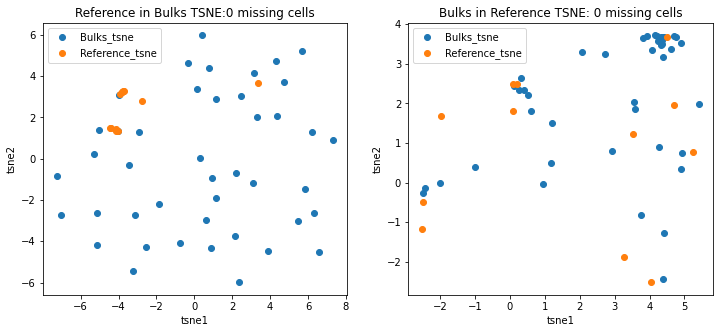

Perplexity value 60 is too high. Using perplexity 14.00 instead


===> Finding 42 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.00, lr=43.00 for 500 iterations...
Iteration   50, KL divergence 0.2487, 50 iterations in 0.2838 sec
Iteration  100, KL divergence 0.2486, 50 iterations in 0.2915 sec
Iteration  150, KL divergence 0.2480, 50 iterations in 0.2893 sec
Iteration  200, KL divergence 0.2464, 50 iterations in 0.2860 sec
Iteration  250, KL divergence 0.2463, 50 iterations in 0.2953 sec
Iteration  300, KL divergence 0.2463, 50 iterations in 0.2848 sec
Iteration  350, KL divergence 0.2463, 50 iterations in 0.2808 sec
Iteration  400, KL divergence 0.2463, 50 iterations in 0.2838 sec
Iteration  450, KL divergence 0.2463, 50 iterations in 0.2834 sec


Perplexity value 60 is too high. Using perplexity 3.00 instead


Iteration  500, KL divergence 0.2463, 50 iterations in 0.2861 sec
   --> Time elapsed: 2.87 seconds
===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=4.00, lr=0.10 for 0 iterations...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=1.50, lr=0.10 for 250 iterations...
Iteration   50, KL divergence 212.5342, 50 iterations in 0.0115 sec
Iteration  100, KL divergence 199.8643, 50 iterations in 0.0109 sec
Iteration  150, KL divergence 196.4842, 50 iterations in 0.0106 sec
Iteration  200, KL divergence 196.3549, 50 iterations in 0.0104 sec
Iteration  250, KL divergence 196.3549, 50 iterations in 0.0113 sec
   --> Time elapsed: 0.05 seconds
===> Finding 15 nearest neighbors in existing embedding using exact search...
   --> Time elapsed: 0.01 seconds
===> Calculating affinity matrix...
   -

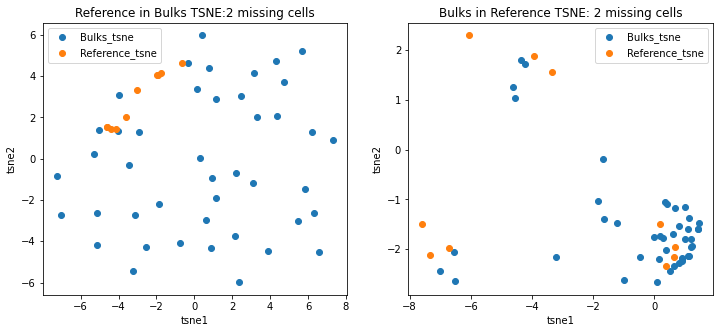

In [121]:
for num in ref_df.keys():
    ref_using = ref_df[num]
    #tsne plots of reference dataframes projected in normalized pseudobulks TSNE 
    #figures
    plt.figure(figsize=(12, 5))
    #data used
    x_train = normalized_bulks.values
    x_test = ref_using.T.values
    #compute the affinities between data points
    affinities_train = affinity.PerplexityBasedNN(
        x_train,
        perplexity=60,
        metric="euclidean",
        n_jobs=8,
        random_state=42,
        verbose=True,
    )
    #initialize coordinates for embedd.
    init_train = initialization.pca(x_train, random_state=42)
    embedding_train = TSNEEmbedding(
        init_train,
        affinities_train,
        negative_gradient_method="fft",
        n_jobs=8,
        verbose=True,
    )
    #optimize embedding
    embedding_train = embedding_train.optimize(n_iter=500)
    #transform both in train embedd.
    tsne_train = embedding_train.transform(x_train)
    tsne_test = embedding_train.transform(x_test)
    plt.subplot(1, 2, 1)
    plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Bulks_tsne" )
    plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Reference_tsne" )
    plt.title(f"Reference in Bulks TSNE:{num} missing cells")
    plt.xlabel("tsne1")
    plt.ylabel("tsne2")
    plt.legend()
    #data used (switching)
    x_train = ref_using.T.values
    x_test = normalized_bulks.values
    #compute the affinities between data points
    affinities_train = affinity.PerplexityBasedNN(
        x_train,
        perplexity=60,
        metric="euclidean",
        n_jobs=8,
        random_state=42,
        verbose=True,
    )
    #initialize coordinates for embedd.
    init_train = initialization.pca(x_train, random_state=42)
    embedding_train = TSNEEmbedding(
        init_train,
        affinities_train,
        negative_gradient_method="fft",
        n_jobs=8,
        verbose=True,
    )
    #optimize embedding
    embedding_train = embedding_train.optimize(n_iter=500)
    #transform both in train embedd.
    tsne_train = embedding_train.transform(x_train)
    tsne_test = embedding_train.transform(x_test)
    plt.subplot(1, 2, 2)
    plt.scatter(tsne_test[:,0], tsne_test[:,1], label = "Bulks_tsne" )
    plt.scatter(tsne_train[:,0], tsne_train[:,1], label = "Reference_tsne" )
    plt.title(f"Bulks in Reference TSNE: {num} missing cells")
    plt.xlabel("tsne1")
    plt.ylabel("tsne2")
    plt.legend()
    plt.show()

## NNLS Deconvolution:

In [127]:
calc_prop_tot = dict()
calc_res_tot = dict()
calc_prop_tot[0], calc_res_tot[0] = vp.calc_nnls_adipose(ref_df[0], normalized_bulks)
calc_prop_tot[2], calc_res_tot[2] = vp.calc_nnls_adipose(ref_df[2], normalized_bulks)

Sample No.:GSM5315252
Sample No.:GSM5315242
Sample No.:GSM5315263
Sample No.:GSM5315270
Sample No.:GSM5315255
Sample No.:GSM5315265
Sample No.:GSM5315259
Sample No.:GSM5315253
Sample No.:GSM5315238
Sample No.:GSM5315257
Sample No.:GSM5315241
Sample No.:GSM5315239
Sample No.:GSM5315269
Sample No.:GSM5315250
Sample No.:GSM5315249
Sample No.:GSM5315264
Sample No.:GSM5315261
Sample No.:GSM5315234
Sample No.:GSM5315248
Sample No.:GSM5315247
Sample No.:GSM5315267
Sample No.:GSM5315235
Sample No.:GSM5315271
Sample No.:GSM5315254
Sample No.:GSM5315251
Sample No.:GSM5315274
Sample No.:GSM5315266
Sample No.:GSM5315246
Sample No.:GSM5315233
Sample No.:GSM5315236
Sample No.:GSM5315240
Sample No.:GSM5315262
Sample No.:GSM5315243
Sample No.:GSM5315272
Sample No.:GSM5315245
Sample No.:GSM5315268
Sample No.:GSM5315258
Sample No.:GSM5315273
Sample No.:GSM5315244
Sample No.:GSM5315256
Sample No.:GSM5315237
Sample No.:GSM5315260
Sample No.:GSM5315232
Sample No.:GSM5315252
Sample No.:GSM5315242
Sample No.

Ordering order of cells:

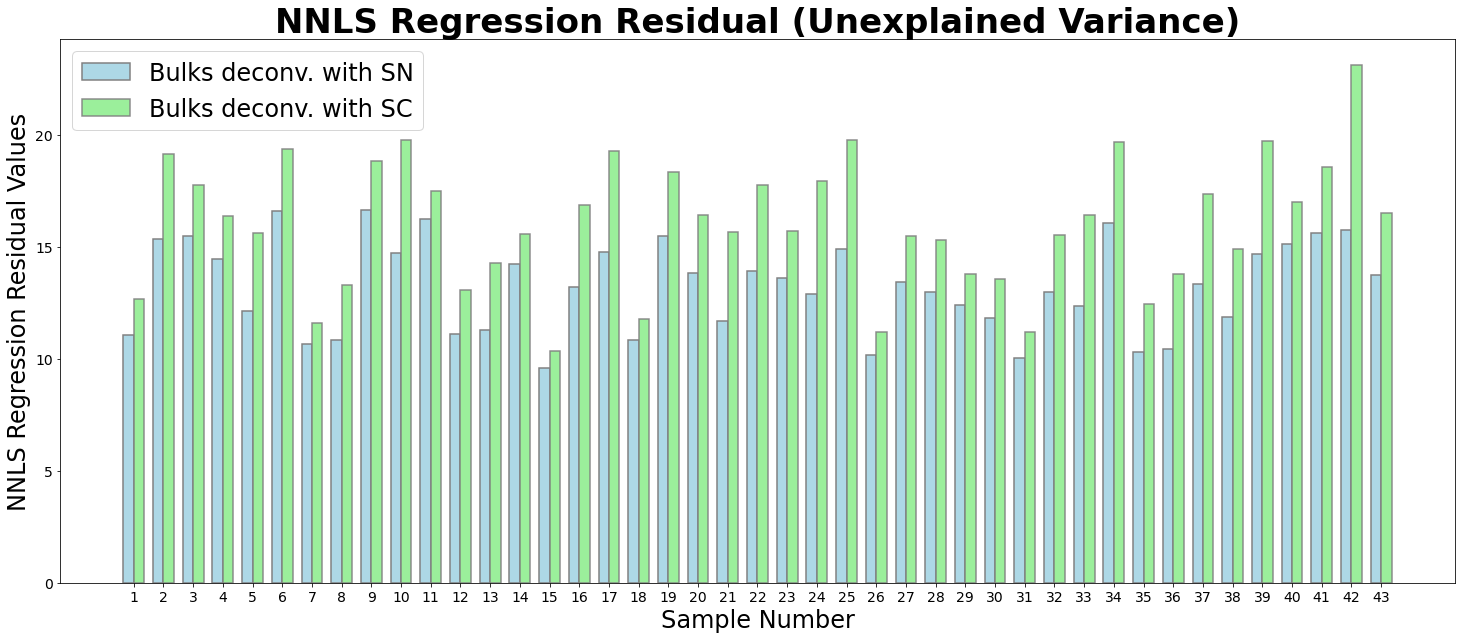

In [126]:
# Sample data 
sn_bulks_values = calc_res_tot[0].values.flatten()
sc_bulks_values = calc_res_tot[2].values.flatten()

# Create x-coordinates for the bars
x_coordinates = np.arange(len(sn_bulks_values))
# Width of each bar
bar_width = 0.35

plt.figure(figsize=(25, 10))

# Plot "sn Bulks" residuals
plt.bar(x_coordinates, sn_bulks_values, width=bar_width, alpha=1, label='Bulks deconv. with SN',
                        color='lightblue', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "sn Bulks" bars
plt.bar(x_coordinates + bar_width, sc_bulks_values, width=bar_width, alpha=0.9, label='Bulks deconv. with SC', 
                        color='lightgreen', edgecolor='grey', linewidth=1.5)

plt.xlabel('Sample Number', fontsize=24)
plt.ylabel('NNLS Regression Residual Values', fontsize=24)

# Make the title bold
plt.title('NNLS Regression Residual (Unexplained Variance)', fontweight='bold', fontsize=34)

plt.xticks(x_coordinates+bar_width/2,range(1,len(normalized_bulks)+1), fontsize=14)  # Adjust x-axis labels
plt.yticks(fontsize=14)  # Adjust y-axis labels
# Move the legend to the upper right corner
plt.legend(loc='best', fontsize=24)

plt.show()

In [26]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
sn_residual = calc_res_tot[0].values
sc_residual = calc_res_tot[2].values
sn_residual=sn_residual.reshape(-1,1)
sn_residual.shape

(43, 1)

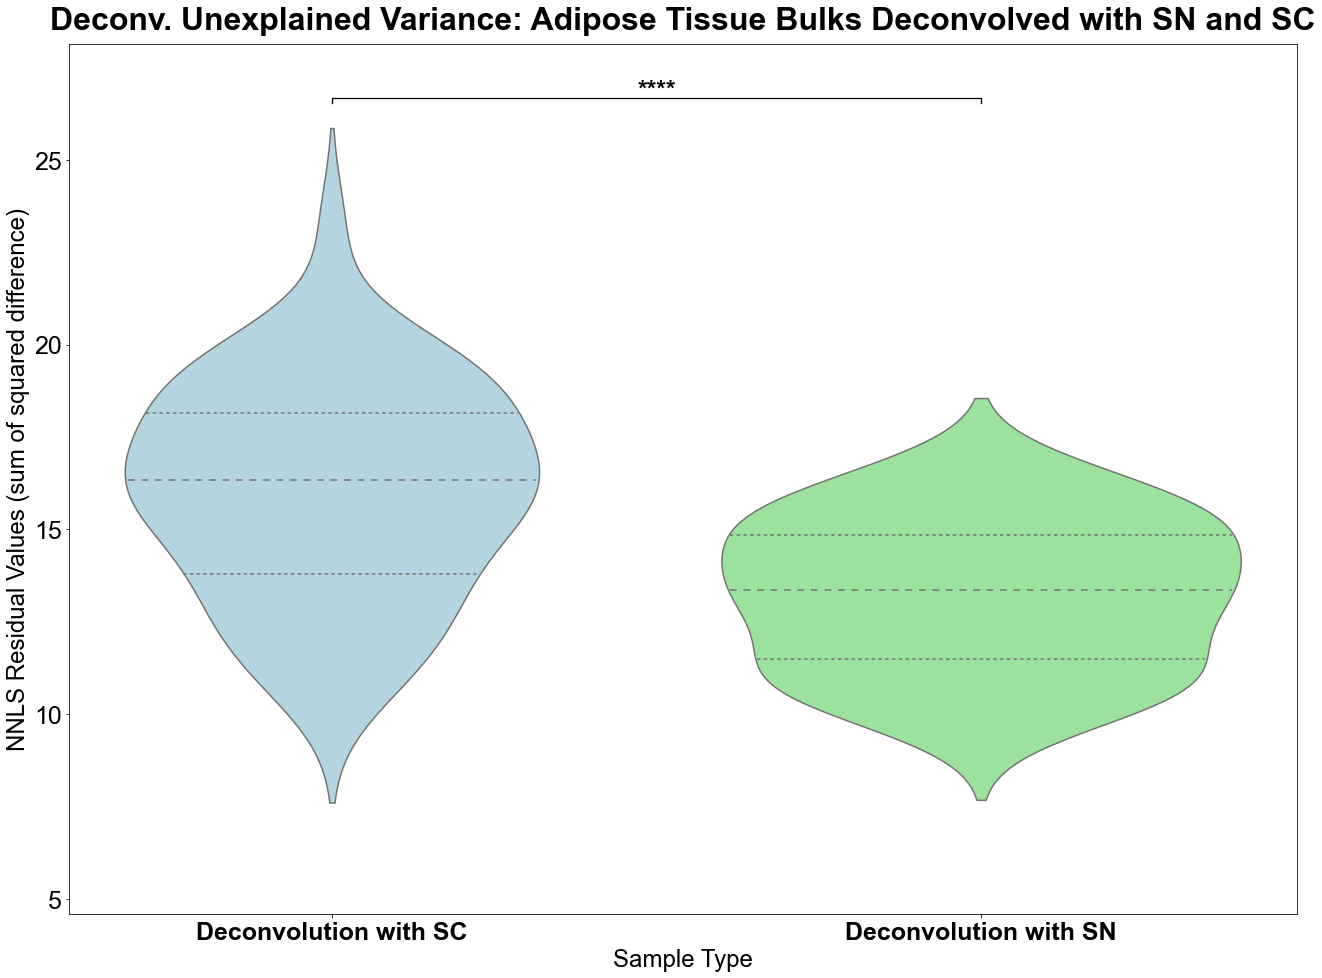

In [27]:
sn_residual = calc_res_tot[0].values
sc_residual = calc_res_tot[2].values
sn_residual=sn_residual.flatten()
sc_residual=sc_residual.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Reference Used': ['BulkType1'] * len(sc_residual) +
                                  ['BulkType2'] * len(sn_residual),
                   'Residuals': np.concatenate([sc_residual, sn_residual])})

# Create a figure and axis for violin plots
plt.figure(figsize=(22, 16))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Reference Used', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Deconvolution with SC', 'Deconvolution with SN'], fontsize=25, fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(sc_residual, sn_residual)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(sc_residual),max(sn_residual)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 3.4, max_val +3.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1.3, color='black')
    plt.text((x1 + x2) / 2, y2-.1, asterisks, ha='center', va='bottom', fontsize=25, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    x1, x2 = 0, 1
    y1, y2 = max_val + 3.4, max_val +3.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.25, "N.S.", ha='center', va='bottom', fontsize=25, fontweight='bold', 
                    fontname='Arial', x=0.5, y=1.03)

plt.xlabel('Sample Type', fontsize=24, fontname='Arial')
plt.ylabel('NNLS Residual Values (sum of squared difference)', fontsize=24, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Adipose Tissue Bulks Deconvolved with SN and SC', fontsize=32, 
                fontname='Arial', fontweight='bold', x=0.5, y=1.01)
plt.ylim(df['Residuals'].min()-5, df['Residuals'].max()+5)
plt.yticks(fontsize=25, fontname='Arial')
plt.show()

## Residuals Prep

In [28]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
sn_recreated_mat_all = pd.DataFrame(ref_df[0] @ calc_prop_tot[0].T)
sn_recreated_mat_all = sn_recreated_mat_all.T
sn_recreated_mat_all.columns = gene_ids
sn_recreated_mat_all   

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
GSM5315252,0.406662,0.192528,0.527098,0.504874,0.518433,0.277482,0.296652,0.230902,0.291881,0.269804,...,0.234584,0.199358,0.486026,0.170580,0.283422,0.361464,0.436615,0.117623,0.288751,0.318752
GSM5315242,0.363026,0.174292,0.451939,0.513109,0.499713,0.219089,0.261454,0.172381,0.303323,0.313470,...,0.238195,0.177188,0.395185,0.191178,0.304730,0.334142,0.354775,0.105292,0.267761,0.280170
GSM5315263,0.293764,0.120069,0.417389,0.519376,0.415959,0.292419,0.198172,0.068985,0.350669,0.278350,...,0.103405,0.139095,0.284453,0.213890,0.262937,0.323704,0.277198,0.137534,0.305514,0.213898
GSM5315270,0.298375,0.113973,0.342728,0.432932,0.320107,0.418275,0.202153,0.079215,0.426178,0.224293,...,0.086986,0.148849,0.285315,0.201065,0.228393,0.358136,0.268422,0.143828,0.304880,0.211636
GSM5315255,0.413787,0.188708,0.662338,0.651783,0.631715,0.218684,0.335246,0.237688,0.184818,0.276243,...,0.147267,0.223167,0.654080,0.176180,0.307216,0.389808,0.604019,0.132677,0.336751,0.379030
GSM5315265,0.332990,0.164564,0.461540,0.507043,0.538796,0.155999,0.198342,0.111854,0.310167,0.389314,...,0.245911,0.141134,0.255171,0.237804,0.325815,0.266116,0.234747,0.104283,0.244983,0.224047
GSM5315259,0.252745,0.094002,0.411322,0.592859,0.414986,0.303796,0.183964,0.025013,0.321006,0.247751,...,0.027811,0.125768,0.250874,0.203541,0.234741,0.305775,0.245343,0.139751,0.308651,0.187502
GSM5315253,0.443358,0.235648,0.657031,0.676439,0.732217,0.119892,0.353603,0.307512,0.127299,0.359408,...,0.287466,0.228580,0.629520,0.142071,0.352992,0.355062,0.590150,0.110467,0.290503,0.399288
GSM5315238,0.380472,0.209135,0.274901,0.317807,0.388823,0.219117,0.219935,0.199600,0.390353,0.362476,...,0.439002,0.150280,0.179910,0.213523,0.312591,0.259303,0.148575,0.080089,0.201462,0.215324
GSM5315257,0.437447,0.231520,0.651484,0.673781,0.723613,0.129346,0.348110,0.300394,0.157540,0.352214,...,0.276605,0.225479,0.616231,0.118656,0.346146,0.374834,0.586057,0.112749,0.277173,0.395068


In [29]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
sc_recreated_mat_all = pd.DataFrame(ref_df[2] @ calc_prop_tot[2].T)
sc_recreated_mat_all = sc_recreated_mat_all.T
sc_recreated_mat_all.columns = gene_ids
sc_recreated_mat_all 

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
GSM5315252,0.379781,0.089168,0.333197,0.416407,0.552021,0.213364,0.119960,0.125750,0.241707,0.201057,...,0.269321,0.092532,0.156438,0.048875,0.243796,0.224235,0.170679,0.032974,0.185744,0.100780
GSM5315242,0.392721,0.093222,0.324382,0.432784,0.576766,0.155570,0.128659,0.117465,0.231326,0.199259,...,0.263455,0.084125,0.165380,0.059340,0.261851,0.186847,0.168886,0.035011,0.177638,0.099277
GSM5315263,0.371743,0.081027,0.394964,0.506400,0.637542,0.185922,0.111780,0.043590,0.244171,0.122459,...,0.087613,0.088559,0.176864,0.055178,0.216596,0.231051,0.183153,0.034365,0.200963,0.094361
GSM5315270,0.381570,0.074320,0.247537,0.340062,0.554419,0.321887,0.118483,0.038847,0.304929,0.105039,...,0.077395,0.098867,0.204338,0.062797,0.211396,0.289768,0.227599,0.045009,0.209653,0.095734
GSM5315255,0.383789,0.088880,0.352674,0.484206,0.615879,0.137542,0.121188,0.092666,0.231592,0.175162,...,0.206263,0.084072,0.167705,0.052267,0.243091,0.199797,0.177228,0.035296,0.195963,0.103068
GSM5315265,0.371270,0.092530,0.477782,0.530161,0.580822,0.155006,0.108633,0.099226,0.183807,0.181631,...,0.209902,0.093366,0.131036,0.061998,0.241323,0.173958,0.106471,0.017517,0.157308,0.082664
GSM5315259,0.363594,0.080479,0.393518,0.519029,0.698969,0.190727,0.120300,0.038644,0.254964,0.117950,...,0.082131,0.082741,0.196823,0.052935,0.225942,0.232498,0.219476,0.042777,0.211391,0.101377
GSM5315253,0.367211,0.099007,0.426816,0.524999,0.673459,0.116339,0.134512,0.159286,0.210351,0.244064,...,0.352108,0.073305,0.156533,0.038642,0.283956,0.170217,0.180703,0.036431,0.178513,0.108515
GSM5315238,0.405309,0.104580,0.181171,0.252859,0.410708,0.196212,0.132111,0.172424,0.214972,0.201973,...,0.428868,0.096987,0.132047,0.065121,0.284906,0.168752,0.137395,0.028588,0.156561,0.096153
GSM5315257,0.373051,0.098056,0.426684,0.516619,0.639422,0.114206,0.128977,0.152979,0.212628,0.236323,...,0.333782,0.075048,0.147736,0.038665,0.276857,0.177843,0.162500,0.032102,0.173672,0.102234


## **Calculate Residuals:**

In [30]:
# Residual as the the difference between the recreated matrix and bulks.
res = normalized_bulks.values - sn_recreated_mat_all.values
residuals_sn = pd.DataFrame(res, columns = sn_recreated_mat_all.columns, index =normalized_bulks.index)
residuals_sn

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
GSM5315252,-0.291447,-0.117937,-0.514965,-0.484149,-0.420298,0.018500,-0.156408,0.769098,-0.064353,-0.211944,...,-0.045110,-0.122661,-0.265281,0.009420,-0.283314,-0.003135,-0.131127,0.087238,-0.102310,-0.073034
GSM5315242,0.134759,-0.047660,-0.301386,0.486891,-0.252774,0.050633,0.450436,0.522966,0.120852,0.046866,...,-0.101353,0.474075,0.098379,0.048822,0.239522,0.355548,0.259725,0.894708,0.014725,0.217738
GSM5315263,0.224699,0.286765,0.382210,0.480624,0.584041,-0.000498,0.591463,-0.025812,0.076121,-0.136739,...,-0.103405,0.521759,-0.124878,0.086110,0.586332,0.037509,0.030496,0.227757,0.010870,0.170403
GSM5315270,0.020680,0.141852,0.278501,0.192745,0.043383,-0.013741,0.012786,0.117117,-0.131284,-0.047985,...,-0.002775,0.299513,-0.053931,-0.061065,0.434553,0.390591,0.068736,0.440033,0.277041,0.049952
GSM5315255,0.023437,0.032688,-0.573151,-0.524725,-0.587258,0.379383,0.158656,-0.036477,-0.168432,-0.210127,...,-0.084109,0.068849,-0.204612,-0.142846,-0.152791,0.359696,-0.127303,0.277382,0.024830,0.333496
GSM5315265,0.396701,0.266192,0.538460,0.492957,0.311710,0.067058,0.188854,-0.025227,0.316006,-0.042757,...,-0.182753,0.410767,0.032063,0.115530,0.674185,0.289291,0.033356,0.329748,0.755017,0.109890
GSM5315259,-0.165594,0.041859,-0.149251,-0.228901,-0.174185,-0.169602,-0.087928,-0.025013,-0.124490,-0.208632,...,-0.027811,0.226306,-0.087975,-0.143541,0.175270,-0.305775,-0.174601,0.384555,-0.048764,-0.187502
GSM5315253,-0.240995,0.137082,-0.610512,-0.428053,-0.627120,-0.062942,-0.070067,0.605931,-0.060085,-0.282273,...,-0.255887,-0.175372,-0.450665,-0.062071,-0.163847,0.188210,-0.242016,0.070092,-0.234006,0.146405
GSM5315238,0.234004,0.150829,-0.096553,0.369183,0.118912,-0.059170,0.313601,0.240659,0.609647,-0.058319,...,0.350471,0.285276,-0.169407,0.786477,0.216576,0.021272,0.044908,0.103943,-0.003722,0.080487
GSM5315257,0.072154,0.456318,-0.591669,-0.033905,-0.632586,-0.065953,0.264695,0.290732,-0.045020,-0.151663,...,-0.097658,0.164834,-0.219289,-0.085323,0.036421,0.267169,-0.129558,0.367484,-0.243274,0.604932


In [31]:
# Residual as the the difference between the recreated matrix and bulks.
res = normalized_bulks.values - sc_recreated_mat_all.values
residuals_sc = pd.DataFrame(res, columns = sc_recreated_mat_all.columns, index =normalized_bulks.index)
residuals_sc

gene_ids,AATF,ABAT,ABCA10,ABCA8,ABCA9,ABCB1,ABCB10,ABCC3,ABCC4,ABCC5,...,ZNF804A,ZNF808,ZNF827,ZNF831,ZNF846,ZNRF1,ZNRF3,ZSCAN31,ZSWIM5,ZSWIM8
GSM5315252,-0.264567,-0.014576,-0.321064,-0.395681,-0.453886,0.082618,0.020284,0.874250,-0.014180,-0.143197,...,-0.079848,-0.015835,0.064307,0.131125,-0.243688,0.134093,0.134809,0.171887,0.000697,0.144937
GSM5315242,0.105064,0.033409,-0.173830,0.567216,-0.329827,0.114151,0.583231,0.577882,0.192850,0.161077,...,-0.126613,0.567139,0.328184,0.180660,0.282401,0.502843,0.445614,0.964989,0.104848,0.398631
GSM5315263,0.146720,0.325807,0.404635,0.493600,0.362458,0.105999,0.677854,-0.000416,0.182618,0.019152,...,-0.087613,0.572295,-0.017289,0.244822,0.632673,0.130162,0.124541,0.330927,0.115422,0.289940
GSM5315270,-0.062515,0.181506,0.373692,0.285615,-0.190930,0.082647,0.096457,0.157484,-0.010035,0.071269,...,0.006815,0.349495,0.027045,0.077203,0.451549,0.458960,0.109559,0.538853,0.372268,0.165855
GSM5315255,0.053434,0.132517,-0.263488,-0.357148,-0.571422,0.460525,0.372714,0.108546,-0.215206,-0.109046,...,-0.143105,0.207944,0.281763,-0.018934,-0.088666,0.549706,0.299488,0.374763,0.165619,0.609458
GSM5315265,0.358421,0.338226,0.522218,0.469839,0.269684,0.068051,0.278562,-0.012599,0.442366,0.164925,...,-0.146744,0.458535,0.156197,0.291336,0.758677,0.381450,0.161632,0.416514,0.842692,0.251272
GSM5315259,-0.276443,0.055381,-0.131448,-0.155072,-0.458168,-0.056532,-0.024263,-0.038644,-0.058448,-0.078831,...,-0.082131,0.269333,-0.033924,0.007065,0.184069,-0.232498,-0.148733,0.481529,0.048496,-0.101377
GSM5315253,-0.164849,0.273723,-0.380297,-0.276614,-0.568363,-0.059389,0.149024,0.754157,-0.143136,-0.166929,...,-0.320529,-0.020098,0.022323,0.041358,-0.094811,0.373055,0.167431,0.144128,-0.122016,0.437178
GSM5315238,0.209168,0.255384,-0.002824,0.434130,0.097028,-0.036265,0.401425,0.267834,0.785028,0.102184,...,0.360605,0.338570,-0.121543,0.934879,0.244262,0.111823,0.056088,0.155443,0.041180,0.199658
GSM5315257,0.136551,0.589782,-0.366869,0.123258,-0.548395,-0.050813,0.483828,0.438147,-0.100108,-0.035773,...,-0.154835,0.315265,0.249206,-0.005332,0.105710,0.464160,0.293999,0.448131,-0.139774,0.897766


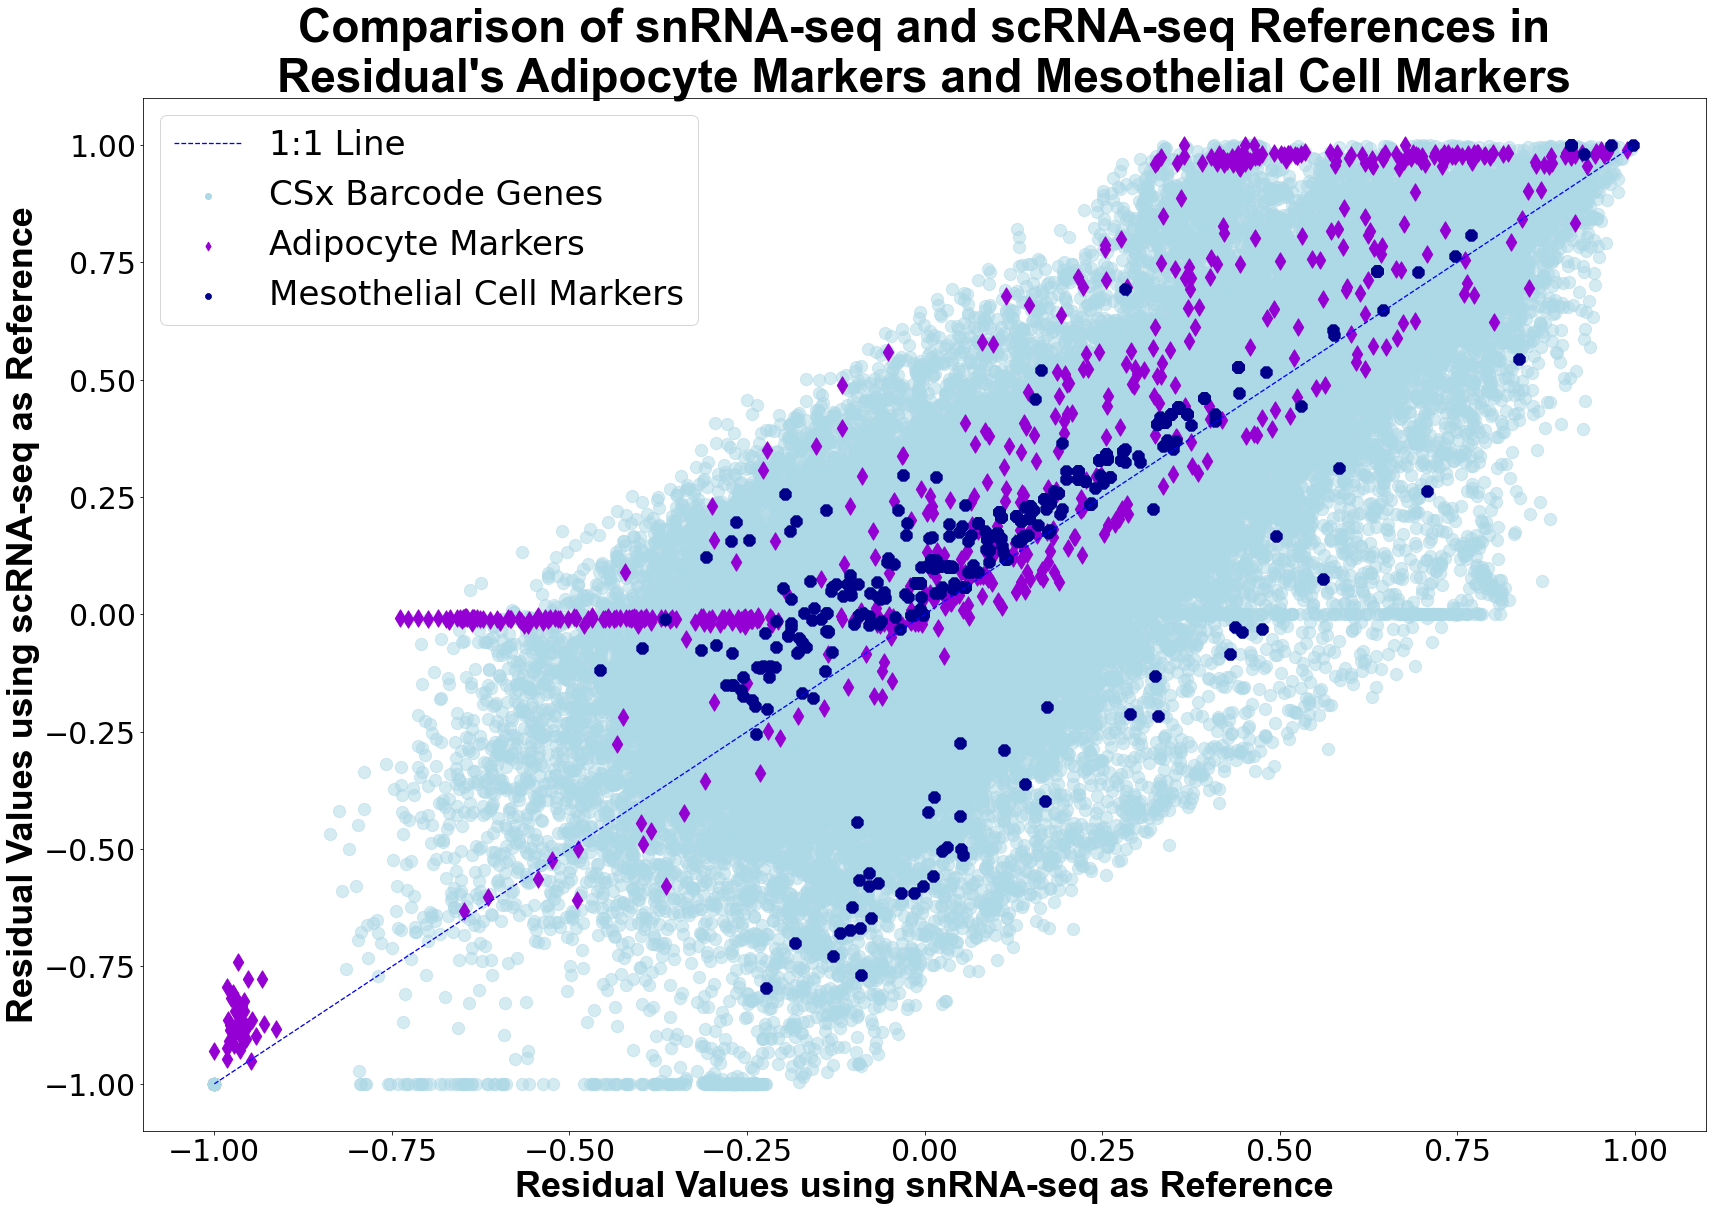

In [37]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(28,19))

# Add dummy points for labels to ensure they appear in the legend
plt.scatter([], [], label='CSx Barcode Genes', c='lightblue')
plt.scatter([], [], label='Adipocyte Markers', c='darkviolet', marker='d')
plt.scatter([], [], label='Mesothelial Cell Markers', c='darkblue', marker='8')

# Plot CIBERSORT genes
for gene in cibersort_genes:
    if gene in residuals_sn.columns:
        gene_data_sc = residuals_sc[gene]
        gene_data_sn = residuals_sn[gene]
        plt.scatter(gene_data_sn, gene_data_sc, alpha=0.5, c='lightblue', s=150)

# Plot Adipocyte markers
for gene in adip_markers:
    if gene in residuals_sn.columns:
        gene_data_sc = residuals_sc[gene]
        gene_data_sn = residuals_sn[gene]
        plt.scatter(gene_data_sn, gene_data_sc, alpha=1, c='darkviolet', marker='d', s=150)

# Plot Mesothelial Cell Markers
for gene in markers_meso:
    if gene in residuals_sn.columns:
        gene_data_sc = residuals_sc[gene]
        gene_data_sn = residuals_sn[gene]
        plt.scatter(gene_data_sn, gene_data_sc, alpha=1, c='darkblue', marker='8', s=150)

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1.3, linestyle='--')

# Set axis labels and title
plt.title("Comparison of snRNA-seq and scRNA-seq References in\nResidual's Adipocyte Markers and Mesothelial Cell Markers", 
                fontsize=46, fontname='Arial', fontweight='bold', x=0.5, y=1.0003)
plt.ylabel('Residual Values using scRNA-seq as Reference', fontsize=36, fontname='Arial', fontweight='bold')
plt.xlabel('Residual Values using snRNA-seq as Reference', fontsize=36, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Add legend
plt.legend(fontsize=34, markerscale=1)

# Show the plot
plt.show()

adipocyte markers:
ADIPOR1
adipocyte markers:
ADIPOR2
adipocyte markers:
CIDEA
adipocyte markers:
FABP4
adipocyte markers:
LGALS12
adipocyte markers:
LEP
adipocyte markers:
PPARG
adipocyte markers:
PLIN1
adipocyte markers:
UCP1
adipocyte markers:
ACVR1C
adipocyte markers:
CIDEC
adipocyte markers:
GPD1
adipocyte markers:
ADIPOQ
adipocyte markers:
MRAP
adipocyte markers:
LIPE
mesothelial markers:
UPK3B
mesothelial markers:
IL18
mesothelial markers:
SOX6
mesothelial markers:
WNT10A
mesothelial markers:
UPK3B
mesothelial markers:
WT1
mesothelial markers:
UPK3B
mesothelial markers:
PRG4
mesothelial markers:
UPK3B
mesothelial markers:
LRRN4
mesothelial markers:
UPK3B


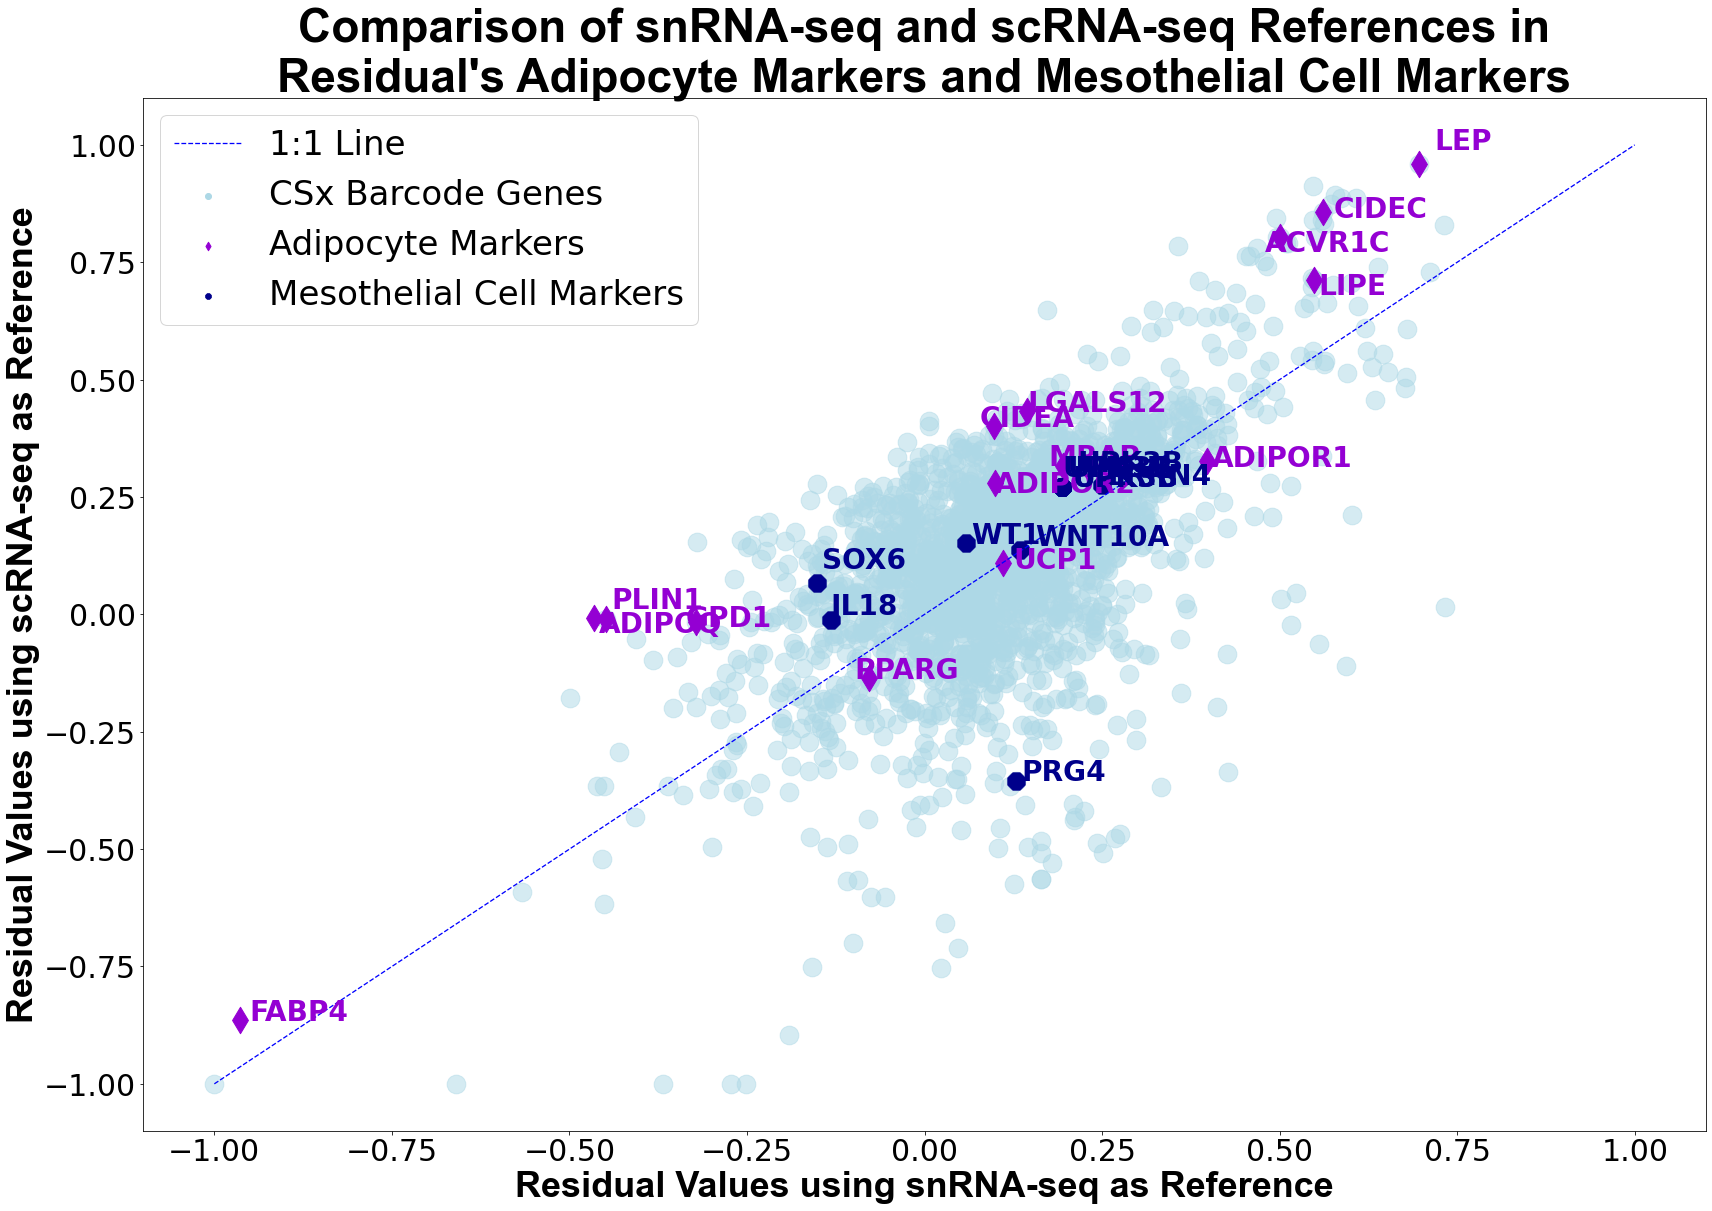

In [94]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(28,19))

# Add dummy points for labels to ensure they appear in the legend
plt.scatter([], [], label='CSx Barcode Genes', c='lightblue')
plt.scatter([], [], label='Adipocyte Markers', c='darkviolet', marker='d')
plt.scatter([], [], label='Mesothelial Cell Markers', c='darkblue', marker='8')

# Track annotated genes to ensure each is labeled only once
annotated_genes = set()
# Plot CIBERSORT genes
for gene in cibersort_genes:
    if gene in residuals_sn.columns:
        gene_data_sc = residuals_sc[gene]
        gene_data_sn = residuals_sn[gene]
        plt.scatter(gene_data_sn.mean(), gene_data_sc.mean(), alpha=0.5, c='lightblue', s=350)

# Plot Adipocyte markers
for gene in adip_markers:
    if gene in residuals_sn.columns:
        gene_data_sc = residuals_sc[gene]
        gene_data_sn = residuals_sn[gene]
        offset_x = random.choice([-15, -10, -5, 0, 5, 10, 15])  # Random x offset
        offset_y = random.choice([-15, -10, -5, 0, 5, 10, 15])  # Random y offset
        plt.scatter(gene_data_sn.mean(), gene_data_sc.mean(), alpha=1, c='darkviolet', marker='d', s=350)
        plt.annotate(
            str(gene), 
            (gene_data_sn.mean(), gene_data_sc.mean()), 
            textcoords="offset points", 
            xytext=(offset_x, offset_y), 
            fontsize=28, fontweight='bold',c='darkviolet'
        )
        print("adipocyte markers:")
        print(gene)

# Plot Mesothelial Cell Markers
for gene in markers_meso:
    if gene in residuals_sn.columns:
        gene_data_sc = residuals_sc[gene]
        gene_data_sn = residuals_sn[gene]
        offset_x = random.choice([ -5, 0, 5, 10, 15])  # Random x offset
        offset_y = random.choice([ -5, 0, 5, 10, 15])  # Random y offset
        plt.scatter(gene_data_sn.mean(), gene_data_sc.mean(), alpha=1, c='darkblue', marker='8', s=350)
        plt.annotate(
            str(gene), 
            (gene_data_sn.mean(), gene_data_sc.mean()), 
            textcoords="offset points", 
            xytext=(offset_x, offset_y), 
            fontsize=28, fontweight='bold',c='darkblue'
        )
        print("mesothelial markers:")
        print(gene)

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1.3, linestyle='--')

# Set axis labels and title
plt.title("Comparison of snRNA-seq and scRNA-seq References in\nResidual's Adipocyte Markers and Mesothelial Cell Markers", 
                fontsize=46, fontname='Arial', fontweight='bold', x=0.5, y=1.0003)
plt.ylabel('Residual Values using scRNA-seq as Reference', fontsize=36, fontname='Arial', fontweight='bold')
plt.xlabel('Residual Values using snRNA-seq as Reference', fontsize=36, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Add legend
plt.legend(fontsize=34, markerscale=1)

# Show the plot
plt.show()

In [33]:
#making copy for numerated index:
res_sc_copy = residuals_sc.copy()
res_sn_copy = residuals_sn.copy()

res_sc_copy.index = range(0,len(bulks))
res_sn_copy.index = range(0,len(bulks))

row_indices =len(bulks) *2

# Define custom colors
custom_colors = ['blue', 'seagreen', 'rosybrown', 'crimson', 'darkcyan', 
                 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 
                 'palevioletred', 'plum', 'orchid', 'mediumorchid', 'darkorchid',
                 'darkblue', 'darkred', 'darkgreen', 'darkorange', 'darkviolet', 
                 'darkcyan', 'darkmagenta', 'powderblue', 'darkblue', 'darkred', 'darkgreen', 
                 'darkorange', 'darkviolet', 'darkcyan', 'darkmagenta', 'cornflowerblue',
                 'darkgoldenrod', 'darkolivegreen', 'darkslategray', 'darkturquoise',
                 'forestgreen', 'indigo', 'mediumblue', 'mediumseagreen', 'mediumslateblue',
                 'cadetblue', 'cornflowerblue', 'darkslateblue',]
np.random.shuffle(custom_colors)
# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a sc_atter plot with labels for multiple genes
plt.figure(figsize=(35, 20))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_sn_copy)))

<Figure size 2520x1440 with 0 Axes>

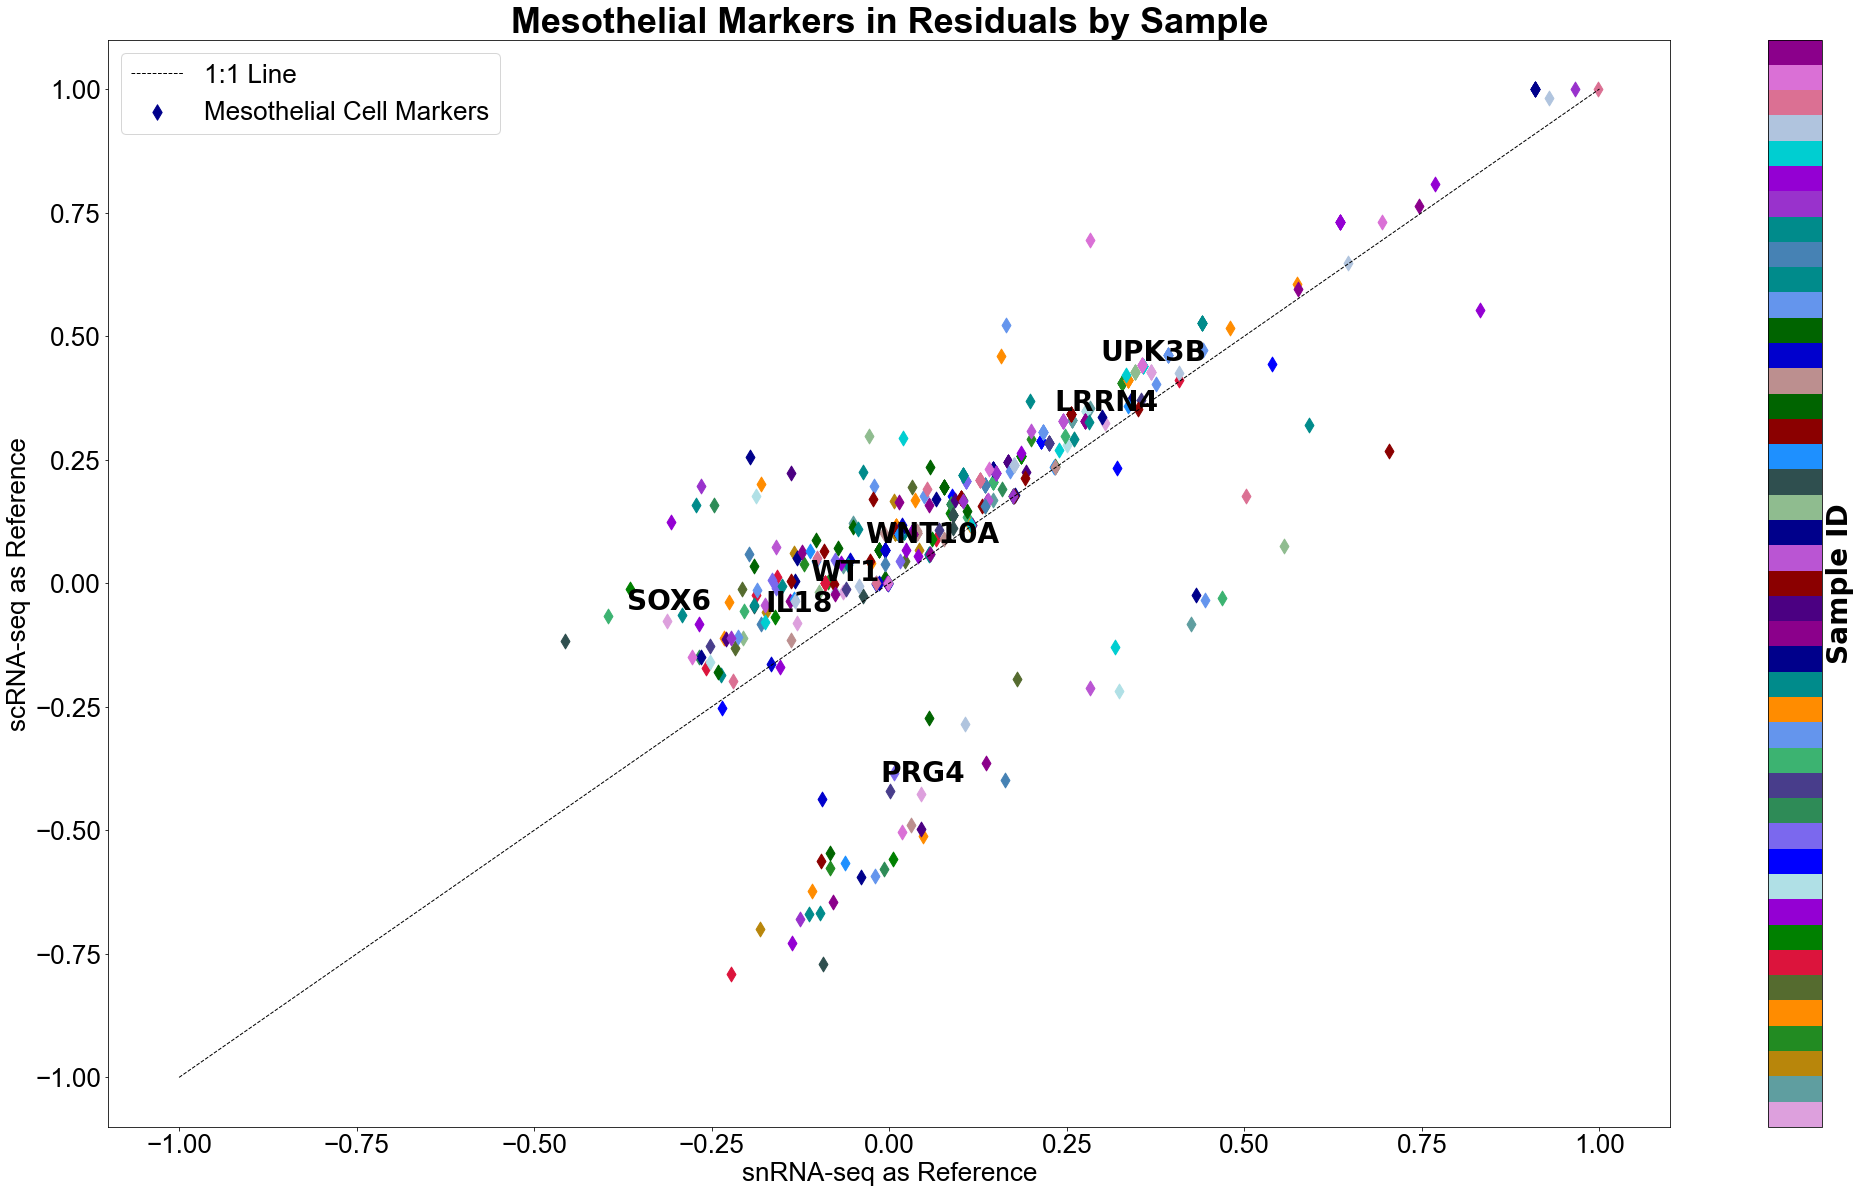

In [34]:
# Create a scatter plot with annotations for each gene only once
plt.figure(figsize=(35, 20))

# Add dummy points for labels to ensure they appear in the legend
plt.scatter([], [], label='Mesothelial Cell Markers', c='darkblue', marker='d', s=120)

# Track annotated genes to ensure each is labeled only once
annotated_genes = set()

# Plot each gene for both bulks and sc
for sample_idx, sample_color in enumerate(unique_colors):
    # Plot Adipocyte markers
    for gene in markers_meso:
        if gene in residuals_sn.columns:
            gene_data_sn = res_sn_copy.at[sample_idx, gene]
            gene_data_sc = res_sc_copy.at[sample_idx, gene]
            plt.scatter(gene_data_sn, gene_data_sc, alpha=1, c=[sample_color], marker='d', s=110,
                        label='Mesothelial Cell Markers' if gene == markers_meso[0] and sample_idx == 0 else "")
            
            # Annotate gene only once at the top of the group
            if gene not in annotated_genes:
                annotated_genes.add(gene)
                plt.annotate(
                    str(gene),
                    (gene_data_sn, gene_data_sc),
                    textcoords="offset points",
                    xytext=(2, 12),  # Position annotation slightly above the point
                    ha='center',
                    fontsize=28,
                    color='black',fontweight='bold'
                )

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='black', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Mesothelial Markers in Residuals by Sample', fontsize=36, fontname='Arial', fontweight='bold')
plt.ylabel('scRNA-seq as Reference', fontsize=26, fontname='Arial')
plt.xlabel('snRNA-seq as Reference', fontsize=26, fontname='Arial')

# Add legend
legend = plt.legend(fontsize=26)
ax = plt.gca()
leg = ax.get_legend()

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(26)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=26, fontname='Arial')
plt.yticks(fontsize=26, fontname='Arial')

# Add colorbar
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)), label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold', fontsize=28)
colorbar.set_ticks([])

# Show the plot
plt.show()


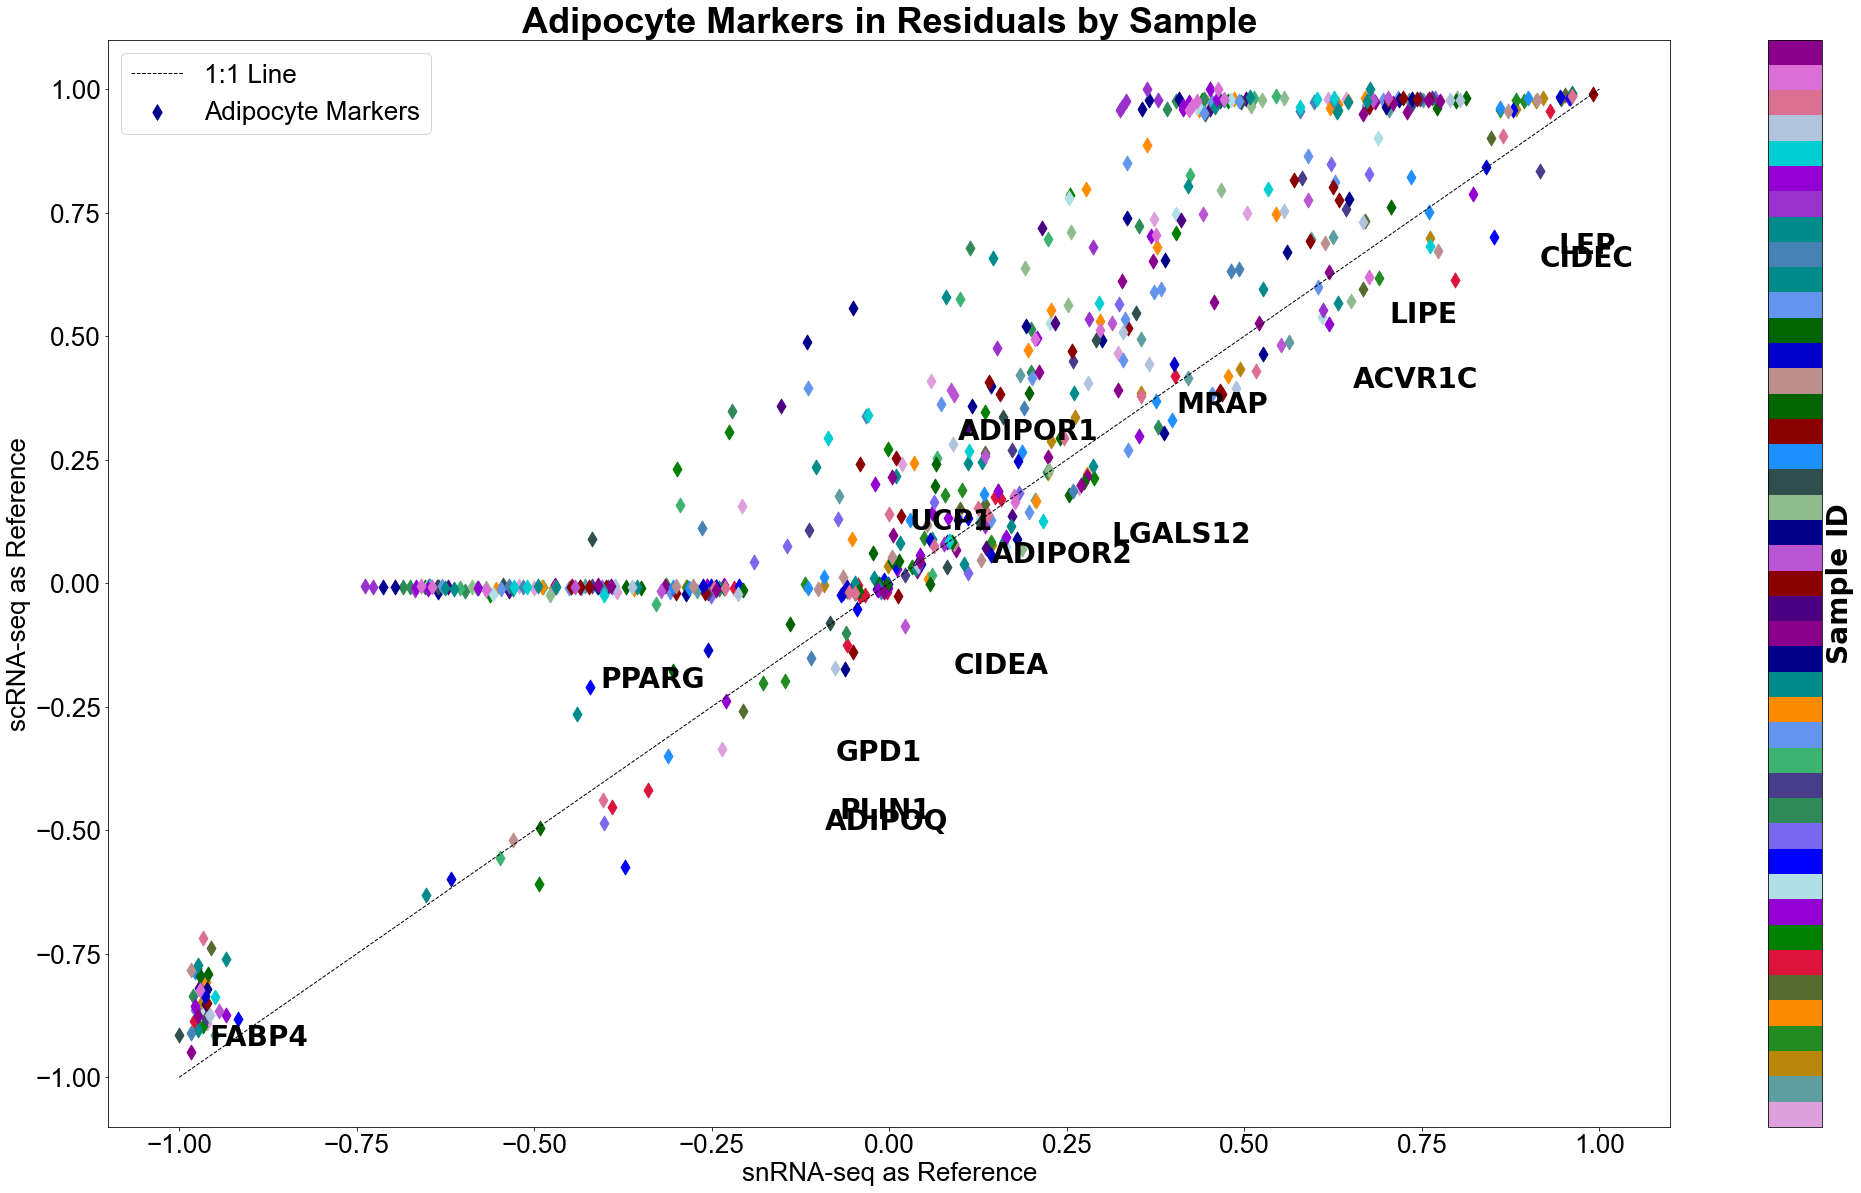

In [35]:
# Create a scatter plot with annotations for each gene only once
plt.figure(figsize=(35, 20))

# Add dummy points for labels to ensure they appear in the legend
plt.scatter([], [], label='Adipocyte Markers', c='darkblue', marker='d', s=120)

# Track annotated genes to ensure each is labeled only once
annotated_genes = set()

# Plot each gene for both bulks and sc
for sample_idx, sample_color in enumerate(unique_colors):
    # Plot Adipocyte markers
    for gene in adip_markers:
        if gene in residuals_sn.columns:
            gene_data_sn = res_sn_copy.at[sample_idx, gene]
            gene_data_sc = res_sc_copy.at[sample_idx, gene]
            plt.scatter(gene_data_sn, gene_data_sc, alpha=1, c=[sample_color], marker='d', s=110,
                        label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
            
            # Annotate gene only once at the top of the group
            if gene not in annotated_genes:
                annotated_genes.add(gene)
                plt.annotate(
                    str(gene),
                    (gene_data_sc, gene_data_sn),
                    textcoords="offset points",
                    xytext=(2, 12),  # Position annotation slightly above the point
                    ha='center',
                    fontsize=28,
                    color='black', fontweight='bold'
                )

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='black', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals by Sample', fontsize=36, fontname='Arial', fontweight='bold')
plt.ylabel('scRNA-seq as Reference', fontsize=26, fontname='Arial')
plt.xlabel('snRNA-seq as Reference', fontsize=26, fontname='Arial')

# Add legend
legend = plt.legend(fontsize=26)
ax = plt.gca()
leg = ax.get_legend()

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(26)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=26, fontname='Arial')
plt.yticks(fontsize=26, fontname='Arial')

# Add colorbar
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)), label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold', fontsize=28)
colorbar.set_ticks([])

# Show the plot
plt.show()


As seen above, mesothelial cell markers and adipocyte cell markers are overall higher in residuals from bulks deconvolved with scRNA-seq compared to residuals of same bulks deconvolved with snRNA-seq.